<a href="https://colab.research.google.com/github/aileendugan/bone-xray-cnn/blob/main/cnn-mura-bone-xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CNN with MURA x-ray images
# ________________________________________________________________________________
# Aileen Dugan, December 2022
#
# The google drive MURA folder can be found here(available to all University of Notre Dame):
# https://drive.google.com/drive/u/1/folders/1oi4cwqoqcoI22BcLPptZf0ZoBgLWt-vK

# Based on Keras documentation available at https://keras.io/examples/vision/mnist_convnet/
# more keras pages used:
# https://keras.io/examples/vision/image_classification_from_scratch/
# https://keras.io/api/data_loading/image/
# https://keras.io/getting_started/intro_to_keras_for_engineers/

# tenserflow pages used:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# stackoverflow pages used
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# https://stackoverflow.com/questions/71897814/adding-images-to-an-array-that-gives-back-number-of-images-and-dimension-of-imag

# NumPy documentation used:
# https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

# Matplotlib documentation used: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_star_poly.html#sphx-glr-gallery-lines-bars-and-markers-scatter-star-poly-py

# pandas documentation used:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.itertuples.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html#pandas.DataFrame.iterrows
#
# kaggle pages used:
# https://www.kaggle.com/code/hrmello/flow-from-dataframe-a-memory-friendly-approach/notebook
# densenet inspiration at https://www.kaggle.com/code/taoofdata/mura-keras-basic-training-loop

# On categorical data: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

# MNIST example at https://colab.research.google.com/drive/1lHzEByuyOZ3fs1q4GKRd6GdzuMHYr_Tg?authuser=1#scrollTo=kc4tyAKWm59Q

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from pathlib import Path
import pandas as pd
import os

#print folder name
print(os.listdir("/content/drive/MyDrive/MURA"))

['MURA-v1.1']


In [ ]:
dataset_root = Path('/content/drive/MyDrive/MURA/MURA-v1.1')

In [ ]:
list(dataset_root.iterdir())

[PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/train_labeled_studies.csv'),
 PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/train_image_paths.csv'),
 PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/valid_labeled_studies.csv'),
 PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/valid_image_paths.csv'),
 PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/valid'),
 PosixPath('/content/drive/MyDrive/MURA/MURA-v1.1/train')]

In [ ]:
#df is the generated dataframe whose head can be visualized below
df = pd.read_csv('/content/drive/MyDrive/MURA/MURA-v1.1/train_image_paths.csv', header=None, names=['filename'])
df.head()

,filename
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [ ]:
#Adding class column to the dataframe with positive or negative label
#Classification is done on basis of the image names (postive/negative)
df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
df['BodyPart'] = (df.filename
               .str.extract('XR_(SHOULDER|ELBOW|FINGER|FOREARM|HAND|HUMERUS|WRIST)'))
df.head()

,filename,class,BodyPart
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,SHOULDER


In [ ]:
df_onlyFinger = df[(df["BodyPart"]=="FINGER")]
df_onlyFinger.head()

,filename,class,BodyPart
9651,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive,FINGER
9652,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive,FINGER
9653,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive,FINGER
9654,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,positive,FINGER
9655,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,positive,FINGER


In [ ]:
df_simpleFinger = df_onlyFinger[["filename","class"]]
df_simpleFinger.head()

,filename,class
9651,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive
9652,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive
9653,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,positive
9654,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,positive
9655,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,positive


In [ ]:
#A function to generate the dataframe for a csv file
def generate_df(dataset_root, csv_name, BODYPART):
    df = pd.read_csv(dataset_root/csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    df['BodyPart'] = (df.filename
               .str.extract('XR_(SHOULDER|ELBOW|FINGER|FOREARM|HAND|HUMERUS|WRIST)'))
    bodypart = df[(df["BodyPart"]==BODYPART)]
    df_onlyOne = bodypart[["filename","class"]]
    return df_onlyOne

In [ ]:
df_train = generate_df(dataset_root, 'train_image_paths.csv',"SHOULDER")
df_train.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


In [ ]:
df_valid = generate_df(dataset_root, 'valid_image_paths.csv',"SHOULDER")
df_valid.head()

,filename,class
1708,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,positive
1709,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,positive
1710,MURA-v1.1/valid/XR_SHOULDER/patient11676/study...,positive
1711,MURA-v1.1/valid/XR_SHOULDER/patient11703/study...,positive
1712,MURA-v1.1/valid/XR_SHOULDER/patient11703/study...,positive


In [ ]:
img_path = '/content/drive/MyDrive/MURA/'

In [ ]:
#take dataframe and make ndarray items for training and testing - fit to densenet keep 3 channels with style from MNIST example instead of generators
x_train = []
y_train = []
for index,row in df_train.iterrows():
  input_arr = cv2.imread(os.path.join(img_path,row["filename"]))
  #, cv2.IMREAD_GRAYSCALE)
  input_arr = cv2.resize(input_arr, (224,224))
  label = row["class"]
  x_train.append(input_arr)
  y_train.append(label)
x_train = np.stack(x_train, axis=0)
y_train = np.array(y_train)

In [ ]:
x_test = []
y_test = []
for index,row in df_valid.iterrows():
  input_arr = cv2.imread(os.path.join(img_path,row["filename"]))
  #, cv2.IMREAD_GRAYSCALE)
  input_arr = cv2.resize(input_arr, (224,224))
  label = row["class"]
  x_test.append(input_arr)
  y_test.append(label)
x_test = np.stack(x_test, axis=0)
y_test = np.array(y_test)

positive


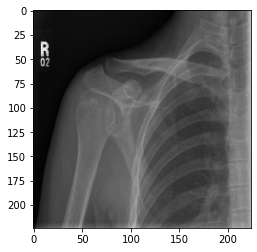

In [ ]:
# Let's show one example from the dataset
image_index = 688 # you may select anything from 0 to 8378 (we have 8379 training samples for shoulder xrays)
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')
plt.show()

# Step 2: Reshaping to 224 x 224 tensors and normalizing pixel intensities to the [0,1] range

for option 1:manual filter picking non densenet169 replace 3s with 1s in code block below

In [ ]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 224, 224, 3)
x_test = x_test.reshape(x_test.shape[0], 224, 224, 3)
input_shape = (224, 224, 3)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the 8-bit grayscale intensities by dividing them by the max intensity value
x_train /= 255
x_test /= 255

# Step 3: Building the convolutional neural network with densenet169 (recommended by MURA dataset users)

Option 1: manually add relu convolutions, flatten,and add dense layers to sequential model

In [ ]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
# *** we need to import implementations of a few extra layers:
from tensorflow.keras import optimizers

# Creating a Sequential Model and adding the layers
model = Sequential()

# *** Now we need to add a few layers. We will use model.add() function:
model.add(Conv2D(filters=16, kernel_size =(5,5), input_shape = input_shape, activation = 'relu'))
model.add(Conv2D(filters=16, kernel_size =(5,5), input_shape = input_shape, activation = 'relu'))
#model.add(Conv2D(filters=16, kernel_size =(5,5), input_shape = input_shape, activation = 'relu'))
#model.add(Conv2D(filters=16, kernel_size =(3,3), input_shape = input_shape, activation = 'relu'))
#model.add(Conv2D(filters=16, kernel_size =(3,3), input_shape = input_shape, activation = 'relu'))
model.add(Flatten())
#model.add(Dense(units=7,activation='softmax'))
#model.add(Dense(units=128,activation='softmax'))
model.add(Dense(units=100,activation='softmax'))
model.add(Dense(units=10,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 16)      6416      
                                                                 
 flatten (Flatten)           (None, 746496)            0         
                                                                 
 dense (Dense)               (None, 100)               74649700  
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 74,657,542
Trainable params: 74,657,542
Non-trainable params: 0
_________________________________________________________________


option 2: Densenet169 (eliminates vanishing gradiant problem) with sequential model with one sigmoid dense layer. convolutional layers include batch normal and relu

In [ ]:
#Downloading the densenet model pretrained on the imagenet dataset
densenet = tf.keras.applications.DenseNet169(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
#Freezing the weights of the pretrained model
densenet.trainable = False

In [ ]:
densenet.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
#Adding the Flatten layer and the sigmoid classification layer to the pretrained densenet model (recommended)
model = tf.keras.models.Sequential([
    densenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 1)                 81537     
                                                                 
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


# Step 4: Training

following option 2: Densenet169 - compile and training

In [ ]:
#Compiling the model using adam optimizer
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

following 3 blocks prepares y data labels to correlate to 0 and 1 for negative and positive (use for both options 1 and 2)

In [ ]:
from sklearn import preprocessing
# prepare labels so that positive and negative map to 0 and 1
def prepare_targets(y_train, y_test):
 le = preprocessing.LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc

In [ ]:
def decode_targets(y_train, prep_label):
 le = preprocessing.LabelEncoder()
 le.fit(y_train)
 label = le.inverse_transform(prep_label)
 #y_test_enc = le.transform(y_test)
 return label

In [ ]:
y_train_enc,y_test_enc = prepare_targets(y_train,y_test)

use code block below for option 1

In [ ]:
epochs = 3  # how many times the network will see the ENTIRE training set

sgd = optimizers.SGD(learning_rate = 0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print('-TRAINING----------------------------')
print('Input shape:', x_train.shape)
print('Number of training images: ', x_train.shape[0])

model.fit(x=x_train, y=y_train_enc, epochs=epochs)

-TRAINING----------------------------
Input shape: (8379, 224, 224, 1)
Number of training images:  8379
Epoch 1/3
262/262 [==============================] - 1201s 5s/step - loss: 0.7393 - accuracy: 0.4966
Epoch 2/3
262/262 [==============================] - 1209s 5s/step - loss: 0.7002 - accuracy: 0.4968
Epoch 3/3
262/262 [==============================] - 1198s 5s/step - loss: 0.6990 - accuracy: 0.5014


use code block below for option 2: densenet169

In [ ]:
epochs = 5
print('-TRAINING----------------------------')
print('Input shape:', x_train.shape)
print('Number of training images: ', x_train.shape[0])

model.fit(x=x_train, y=y_train_enc, epochs=epochs)

-TRAINING----------------------------
Input shape: (8379, 224, 224, 3)
Number of training images:  8379
Epoch 1/5
262/262 [==============================] - 1574s 6s/step - loss: 1.1167 - accuracy: 0.6484
Epoch 2/5
262/262 [==============================] - 1555s 6s/step - loss: 0.8418 - accuracy: 0.7334
Epoch 3/5
262/262 [==============================] - 1550s 6s/step - loss: 0.6444 - accuracy: 0.7894
Epoch 4/5
262/262 [==============================] - 1502s 6s/step - loss: 0.4345 - accuracy: 0.8417
Epoch 5/5
262/262 [==============================] - 1518s 6s/step - loss: 0.4868 - accuracy: 0.8385


# Step 5: Let's see what the network learned: evaluate it on test (unseen) data

remove 4th value "3" on line 14 and 3rd value "3" on line 20 in code block below for option 1. keep same for option 2:Densenet169

-TESTING-----------------------------
Number of test images: 563
18/18 [==============================] - 107s 6s/step - loss: 1.3024 - accuracy: 0.6785
Test loss: 1.3024436235427856
Test accuracy: 0.6785079836845398
1/1 [==============================] - 0s 257ms/step


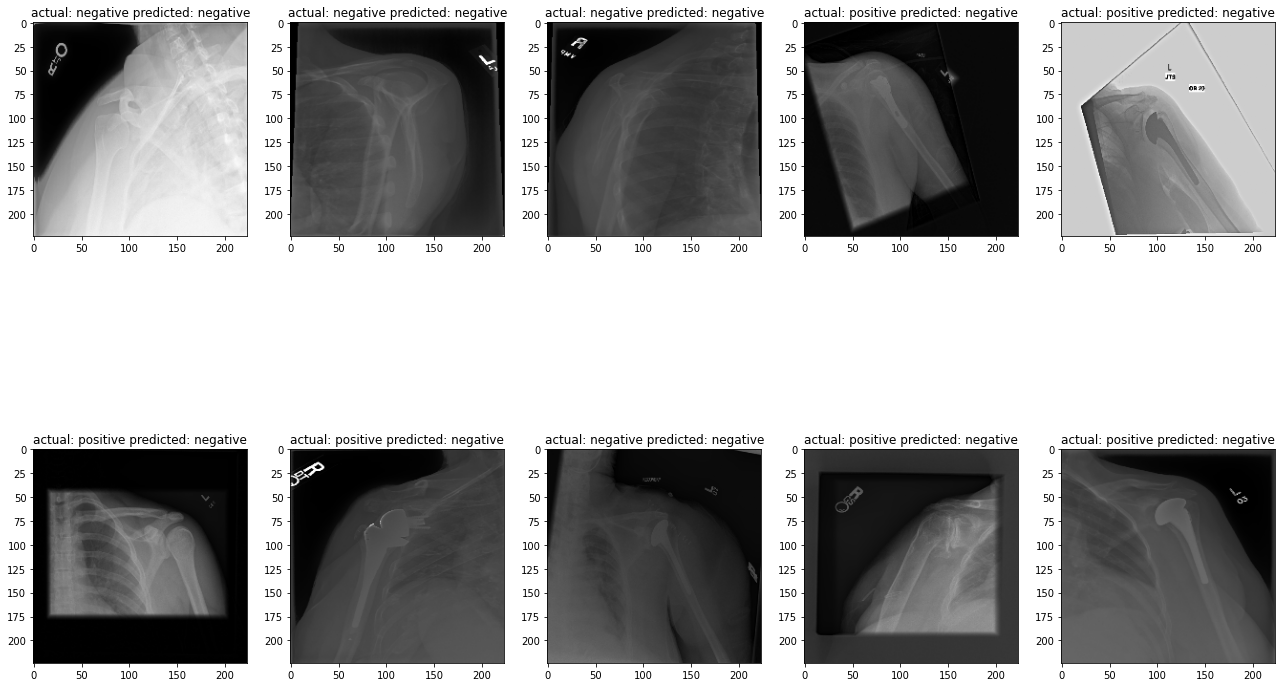

In [ ]:
print('-TESTING-----------------------------')
print('Number of test images:', x_test.shape[0])
score = model.evaluate(x_test, y_test_enc)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print 10 example test digits with their true and predicted labels
fig, axes = plt.subplots(2, 5)
fig.tight_layout(rect=(0,0,3,3))

image_idx = np.random.randint(1,562,(2,5))

for i, j in it.product(range(2), range(5)):
    test_image = x_test[image_idx[i,j]].reshape(1, 224, 224, 3)
    test_label = y_test[image_idx[i,j]]
    sigmoid_outputs = model.predict(test_image)
    pred_label = sigmoid_outputs.argmax()
    pred_label = decode_targets(y_train,[pred_label])

    axes[i, j].imshow(test_image.reshape(224, 224,3),cmap='Greys')
    axes[i, j].set_aspect('equal', 'box')
    axes[i, j].set_title("actual: {} predicted: {}".format(test_label,pred_label[0]))

plt.show()

# Optional step 6: visualize learned kernels in the convolutional layer

NameError: ignored

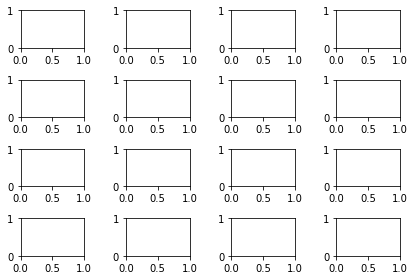

In [ ]:
for layer in model.layers:
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()

        # normalize filter values to 0-1 so we can visualize them
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)

fig, axes = plt.subplots(4, 4)
fig.tight_layout()

for i, j in it.product(range(4),range(4)):
    axes[i, j].imshow(filters[:,:,0,(i+1)*(j+1)-1],cmap='Greys')
    axes[i, j].set_aspect('equal', 'box')

plt.setp(axes, xticks = [], yticks = [])
plt.show()

In [ ]:
#Dividing the image data generated into train set and validation set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
#Creating training set
train_gen = datagen.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv',"SHOULDER"),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')
#Creating validation set
valid_gen = datagen.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv',"SHOULDER"),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')